<h1 style="text-align:center;">Machine Translation (MT)</h1>

<br>

## 1. Initial Deployment

---

In [2]:
# Import the libraries
import nltk, re, tqdm, typing
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Any, Tuple
%matplotlib inline

<br>

## 2. Load Dataset

---

In [ ]:
# # Load datasets using HuggingFace
# opus_books = load_dataset("opus_books", "en-fr")    # OPUS Books
# wmt14 = load_dataset("wmt14", 'fr-en')              # WMT-14

# # Initialize a dictionary
# dataset = {"en": [], "fr": []}

# # Loop over the datasets
# for i_dataset in ["opus_books", "wmt14"]:

#     # Retrive the dataset
#     i_dataset = globals()[i_dataset]

#     # Loop over the rows of dataset
#     for i in i_dataset.data["train"]["translation"].to_numpy():

#         # Append to dictionary
#         dataset["en"].append(i["en"])
#         dataset["fr"].append(i["fr"])
    
# # Convert to dataframe
# pd.DataFrame(dataset)

In [4]:
# Load the english dataset
with open("./dataset/en.txt", ) as f:
    en = f.read().split("\n")

# Load the french dataset
with open("./dataset/fr.txt") as f:
    fr = f.read().split("\n")

# Report
print("English: \n", en[:2])
print("\nFrench: \n", fr[:2])

English: 
 ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']

French: 
 ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .']


<br>

## 3. Text Preprocessing

---

In [5]:
# Function for preprocessing the texts
def text_preprocessing(text):

    # Lowercase
    text = text.lower()

    # Remove unnecessary characters
    text = re.sub(r"[/.,|?><;:±!@#$%^&*()_+=-]", " ", text)

    # Remove extra empty spaces
    text = " ".join(text.split())

    return text

In [7]:
# Preprocess the texts
en = np.array([text_preprocessing(i) for i in tqdm.tqdm(en, ncols=100, colour="blue")])
fr = np.array([text_preprocessing(i) for i in tqdm.tqdm(fr, ncols=100, colour="blue")])

# Report
print("English: \n", en[:2])
print("\nFrench: \n", fr[:2])

100%|███████████████████████████████████████████████████| 137861/137861 [00:00<00:00, 334696.83it/s]

English: 
 ['new jersey is sometimes quiet during autumn and it is snowy in april'
 'the united states is usually chilly during july and it is usually freezing in november']

French: 
 ["new jersey est parfois calme pendant l' automne et il est neigeux en avril"
 'les ã©tats unis est gã©nã©ralement froid en juillet et il gã¨le habituellement en novembre']


<br>

## 4. Feature Extraction

---

In [8]:
# Function for creating Word2Int and Int2Word
def prepare_word_dictionay(list_of_texts, language):

    # Unique tokens
    text = " ".join(list_of_texts.ravel()).lower()                  # Convert list of strings into one string
    tokens = nltk.tokenize.word_tokenize(text, language=language)   # Tokenize
    unique_tokens = np.unique(tokens)                               # Unique tokens

    # Initialize Word2Int
    word2int = {}

    # Add necessary tags  
    word2int["<SOS>"] = 1        # Start-of-sequence <SOS> tag
    word2int["<EOS>"] = 2        # End-of-sequence <EOS> tag
    word2int["<UNK>"] = 3        # Unknown <UNK> tag

    # Loop over unique tokens
    for i_token in tqdm.tqdm(unique_tokens, ncols=100, colour="blue"):

        # Add to Word2Int
        word2int[i_token] = max(word2int.values())+1

    # Make Int2Word
    int2word = {idx: word for word, idx in word2int.items()}

    return word2int, int2word

In [9]:
# Create word2int and int2word
word2int_en, int2word_en = prepare_word_dictionay(list_of_texts=en, language="english")
word2int_fr, int2word_fr = prepare_word_dictionay(list_of_texts=fr, language="french")

100%|█████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 344056.23it/s]


In [10]:
# Label encoding function; For converting words to numerical values
def label_encoding(text, word2int, language):

    # Tokenize
    tokens = nltk.tokenize.word_tokenize(text, language=language)

    # Add staring/ending tag
    tokens.insert(0, "<SOS>")
    tokens.insert(len(tokens), "<EOS>")

    # Initialize a list
    encoded_tokens = []

    # Loop over tokens
    for i in tokens:

        # Append idx if it exist
        try: encoded_tokens.append(word2int[i])

        # Append <UNK> if it doesn't exist
        except: encoded_tokens.append(word2int["<UNK>"])

    return encoded_tokens


# Label decoding function; For converting numerical values to words
def label_decoding(tokens, int2word):

    # Initialize a list
    decoded_tokens = []

    # Loop over tokens
    for i in tokens:

        # Append word if it exist
        try: decoded_tokens.append(int2word[i])

        # Append <UNK> if it doesn't exist
        except: decoded_tokens.append("<UNK>")

    return decoded_tokens

In [11]:
# Label encode the texts
en_label_encoded = [label_encoding(i, language="english", word2int=word2int_en) for i in tqdm.tqdm(en, ncols=100, colour="blue", total=en.shape[0])]
fr_label_encoded = [label_encoding(i, language="french", word2int=word2int_fr) for i in tqdm.tqdm(fr, ncols=100, colour="blue", total=fr.shape[0])]

# Report
print("English: \n", en_label_encoded[:1])
print("\nFrench: \n", fr_label_encoded[:1])

100%|████████████████████████████████████████████████████| 137861/137861 [00:10<00:00, 12871.79it/s]

English: 
 [[1, 123, 92, 89, 158, 141, 53, 16, 7, 90, 89, 157, 87, 12, 2]]

French: 
 [[1, 206, 154, 109, 226, 53, 229, 157, 4, 32, 110, 145, 109, 205, 101, 37, 2]]


In [12]:
# Function for padding the sequence
def padding(label_encoded_seq, max_len):

    # Pad the sequences
    padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences=label_encoded_seq, maxlen=max_len, 
                                                               padding="post", truncating="post")

    return padded_seq

In [13]:
# Maximum length for padding
max_len = max(max([len(i) for i in en_label_encoded]), max([len(i) for i in fr_label_encoded]))

# Pad the sequences
en_label_encoded = padding(en_label_encoded, max_len) 
fr_label_encoded = padding(fr_label_encoded, max_len) 

# Report
print("Shape of int tokens EN: ", en_label_encoded.shape)
print("Shape of int tokens FR: ", fr_label_encoded.shape)

Shape of int tokens EN:  (137861, 26)
Shape of int tokens FR:  (137861, 26)


In [14]:
# One-hot encoding; Function for converting numerical values to binary vectors
def one_hot_encoding(label_encoded_seq, length):

    # Initialize a list for one hot encoded
    one_hot_encoded = []
    
    # Loop over each token in the sequence
    for i_token in label_encoded_seq:

        # Initialize zero vector
        #token = np.zeros(shape=length)
        token = [0 for _ in range(length)]
        
        # Set one
        token[i_token] = 1

        # Append to the list
        one_hot_encoded.append(token)

    #return np.array(one_hot_encoded)
    return one_hot_encoded


# Function for one hot decoding
def one_hot_decoding(tokens):

    # Initialize a list for one hot decoded
    one_hot_decoded = []
        
    # Loop over each token in the sequence
    for i_token in tokens:

        # Append to the list
        one_hot_decoded.append(np.argmax(i_token))

    #return np.array(one_hot_decoded)
    return one_hot_decoded

In [15]:
# One-hot encoding
#en_one_hot_encoded = np.array([one_hot_encoding(i, length=len(word2int_en)+1) for i in tqdm.tqdm(en_label_encoded, ncols=100, colour="blue")])
#fr_one_hot_encoded = np.array([one_hot_encoding(i, length=len(word2int_fr)+1) for i in tqdm.tqdm(fr_label_encoded, ncols=100, colour="blue")])
en_one_hot_encoded = [one_hot_encoding(i, length=len(word2int_en)+1) for i in tqdm.tqdm(en_label_encoded, ncols=100, colour="blue")]
fr_one_hot_encoded = [one_hot_encoding(i, length=len(word2int_fr)+1) for i in tqdm.tqdm(fr_label_encoded, ncols=100, colour="blue")]

# Report
#print("Shape of int tokens EN: ", en_one_hot_encoded.shape)
#print("Shape of int tokens FR: ", fr_one_hot_encoded.shape)

100%|█████████████████████████████████████████████████████| 137861/137861 [00:57<00:00, 2417.49it/s]


In [16]:
# Function for splitting the dataset into training/testing set
def split_train_test(x, y, train_ratio=0.95):

    # Find the dividing index
    #div_idx = int(x.shape[0]*train_ratio)
    div_idx = int(len(x)*train_ratio)

    # Training set
    x_train, y_train = x[:div_idx], y[:div_idx]

    # Testing set
    x_test, y_test = x[div_idx:], y[div_idx:]

    return x_train, y_train, x_test, y_test

In [17]:
# Split the dataset into training and testing set
x_train, y_train, x_test, y_test = split_train_test(x=en_one_hot_encoded, y=fr_one_hot_encoded, train_ratio=0.95)

# Report
# print("x-train shape: ", x_train.shape) 
# print("y-train Shape: ", y_train.shape)
# print("x-test Shape:  ", x_test.shape)
# print("y-test Shape:  ", y_test.shape)

In [18]:
x_train, y_train, x_test, y_test = tf.constant(x_train), tf.constant(y_train), tf.constant(x_test), tf.constant(y_test)

<br>

## 4. Model Construction

---

In [19]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

<br>

### 4.1. SIMPLE RNN MODEL

In [22]:
# Input data
input_data  = en_tokens_one_hot
print(f"Input Data - {input_data.shape}: ")
print(input_data[0])

Input Data - (137861, 25, 203): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [23]:
# Output data
output_data  = fr_tokens_one_hot
print(f"\nOutput Data - {output_data.shape}: ")
print(output_data[0])


Output Data - (137861, 25, 348): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [24]:
# Get input/output shape
input_tokens_num  = input_data.shape[-1]
output_tokens_num = output_data.shape[-1]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 203)]       0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       2932736   
 l)                                                              
                                                                 
 output (Dense)              (None, None, 348)         356700    
                                                                 
Total params: 3,289,436
Trainable params: 3,289,436
Non-trainable params: 0
_________________________________________________________________
None


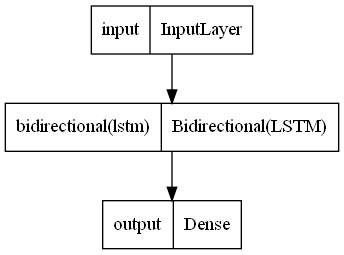

In [25]:
# Input 
input = tf.keras.layers.Input(shape = (None, input_tokens_num), name="input")

# LSTM
lstm_bi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(input)

# Output
output = tf.keras.layers.Dense(output_tokens_num, activation='softmax', name="output")(lstm_bi)    

# Model construction
model = tf.keras.Model(input, output)

# Compile the model
model.compile(loss="categorical_crossentropy",    
              optimizer='adam', 
              metrics=['accuracy'])

# Model summary
print(model.summary())
plot_model(model)

In [26]:
# Train the model
model.fit(input_data,
           output_data,
           batch_size=32,
           epochs=10,
           validation_split=0.2)

Epoch 1/10
3447/3447 [==============================] - 41s 10ms/step - loss: 0.5247 - accuracy: 0.8511 - val_loss: 0.2110 - val_accuracy: 0.9317
Epoch 2/10
3447/3447 [==============================] - 36s 10ms/step - loss: 0.1546 - accuracy: 0.9498 - val_loss: 0.1310 - val_accuracy: 0.9574
Epoch 3/10
3447/3447 [==============================] - 36s 10ms/step - loss: 0.1032 - accuracy: 0.9663 - val_loss: 0.0975 - val_accuracy: 0.9687
Epoch 4/10
3447/3447 [==============================] - 36s 10ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 0.0849 - val_accuracy: 0.9726
Epoch 5/10
3447/3447 [==============================] - 36s 10ms/step - loss: 0.0651 - accuracy: 0.9786 - val_loss: 0.0734 - val_accuracy: 0.9764
Epoch 6/10
3447/3447 [==============================] - 36s 11ms/step - loss: 0.0546 - accuracy: 0.9819 - val_loss: 0.0693 - val_accuracy: 0.9787
Epoch 7/10
3447/3447 [==============================] - 36s 10ms/step - loss: 0.0479 - accuracy: 0.9842 - val_loss: 0.0628 -

In [27]:
# Model evaluation
model.evaluate(input_data, output_data)

4309/4309 [==============================] - 21s 5ms/step - loss: 0.0316 - accuracy: 0.9902


[0.03159509226679802, 0.9901622533798218]

In [48]:
# Function fro making inference
def inference(sent):

    # Preprocess the sentence
    sent = text_preprocessing(sent)

    # Encode the sentence
    sent = encode(sent, language="english", word2int=word2int_en)

    # Pad the sequence
    sent_int = tf.keras.preprocessing.sequence.pad_sequences(sequences=[sent], maxlen=max_pad, padding="post", truncating="post")

    # One-hot encoding
    sent_one_hot = one_hot_encode(sequences=sent_int, tokens_num=len(word2int_en))

    # Predict the model
    prediction = model.predict(sent_one_hot)

    # One-hot decoding
    pred_sent = one_hot_decode(prediction)

    # Decode the sentence
    pred_sent = decode(pred_sent[0], int2word=int2word_fr, word2int=word2int_fr)

    return pred_sent

In [53]:
print("INPUT:      ", en[0])
print("PREDICTION: ", inference(sent=en[0]))
print("OUTPUT:     ", fr[0])

INPUT:       new jersey is sometimes quiet during autumn   and it is snowy in april  


100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

PREDICTION:  new jersey est parfois calme pendant <UNK> <UNK> automne et il est neigeux en avril
OUTPUT:      new jersey est parfois calme pendant l' automne   et il est neigeux en avril  


<br>

### 4.2. ENCODER-DECODER (VANILLA)

In [54]:
# Encoder data
encoder_data  = en_tokens_one_hot
print(f"Encoder Input Data - {encoder_data.shape}: ")
print(encoder_data[0])

Encoder Input Data - (137861, 25, 203): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [55]:
# Decoder data
decoder_data  = fr_tokens_one_hot
print(f"\nDecoder Input Data - {decoder_data.shape}: ")
print(decoder_data[0])


Decoder Input Data - (137861, 25, 348): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [56]:
num_encoder_tokens = 203 #len(word2int_en)
num_decoder_tokens = 348 #len(word2int_fr)
n_repeat_vector = max_pad
latent_dim = 512

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 203)]       0         
                                                                 
 encoder (LSTM)              (None, 512)               1466368   
                                                                 
 decoder_1 (RepeatVector)    (None, 25, 512)           0         
                                                                 
 decoder_2 (LSTM)            (None, 25, 512)           2099200   
                                                                 
 FCL (Dense)                 (None, 25, 512)           262656    
                                                                 
 output (Dense)              (None, 25, 348)           178524    
                                                                 
Total params: 4,006,748
Trainable params: 4,006,748
Non-tra

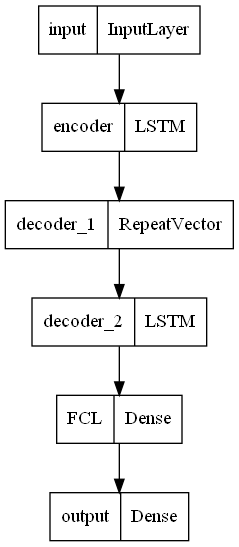

In [57]:
# Input sequence
input_sequence = tf.keras.layers.Input(shape = (None, num_encoder_tokens), name="input")

# Encoder - LSTM layer
encoder = tf.keras.layers.LSTM(units = latent_dim, return_sequences = False, name="encoder")(input_sequence)

# Decoder - Repeat vector for N times
repeat_vector = tf.keras.layers.RepeatVector(n_repeat_vector, name="decoder_1")(encoder)

# Decoder - LSTM layer
decoder = tf.keras.layers.LSTM(units = latent_dim, return_sequences = True, name="decoder_2")(repeat_vector)

# Fully Connected Layer
fully_connected_layer = tf.keras.layers.Dense(units = latent_dim, activation = 'relu', name="FCL")(decoder)

# Output
logits = tf.keras.layers.Dense(units = num_decoder_tokens, activation = "softmax", name="output")(fully_connected_layer)

# Model
model = tf.keras.Model(inputs = input_sequence, outputs = logits)

# Compile the model
model.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ['accuracy'])

# Summary
print(model.summary())

# Plot the model
plot_model(model)

In [58]:
# Train the model
model.fit(encoder_data,
          decoder_data,
          epochs=10,
          batch_size=256,
          validation_split=0.2)

Epoch 1/10
431/431 [==============================] - 19s 39ms/step - loss: 1.7876 - accuracy: 0.5784 - val_loss: 1.1338 - val_accuracy: 0.6764
Epoch 2/10
431/431 [==============================] - 17s 38ms/step - loss: 1.0187 - accuracy: 0.7040 - val_loss: 0.9298 - val_accuracy: 0.7228
Epoch 3/10
431/431 [==============================] - 16s 38ms/step - loss: 0.8028 - accuracy: 0.7555 - val_loss: 0.7181 - val_accuracy: 0.7771
Epoch 4/10
431/431 [==============================] - 17s 38ms/step - loss: 0.6678 - accuracy: 0.7889 - val_loss: 0.6035 - val_accuracy: 0.8075
Epoch 5/10
431/431 [==============================] - 17s 38ms/step - loss: 0.5363 - accuracy: 0.8281 - val_loss: 0.4887 - val_accuracy: 0.8432
Epoch 6/10
431/431 [==============================] - 17s 39ms/step - loss: 0.4114 - accuracy: 0.8689 - val_loss: 0.3628 - val_accuracy: 0.8847
Epoch 7/10
431/431 [==============================] - 17s 39ms/step - loss: 0.3064 - accuracy: 0.9046 - val_loss: 0.2488 - val_accuracy:

In [59]:
# Model evaluation
model.evaluate(input_data, output_data)

4309/4309 [==============================] - 22s 5ms/step - loss: 0.1284 - accuracy: 0.9589


[0.12842249870300293, 0.9588800072669983]

In [60]:
# Function fro making inference
def inference(sent):

    # Preprocess the sentence
    sent = text_preprocessing(sent)

    # Encode the sentence
    sent = encode(sent, language="english", word2int=word2int_en)

    # Pad the sequence
    sent_int = tf.keras.preprocessing.sequence.pad_sequences(sequences=[sent], maxlen=max_pad, padding="post", truncating="post")

    # One-hot encoding
    sent_one_hot = one_hot_encode(sequences=sent_int, tokens_num=len(word2int_en))

    # Predict the model
    prediction = model.predict(sent_one_hot)

    # One-hot decoding
    pred_sent = one_hot_decode(prediction)

    # Decode the sentence
    pred_sent = decode(pred_sent[0], int2word=int2word_fr, word2int=word2int_fr)

    return pred_sent

print("INPUT:      ", en[0])
print("PREDICTION: ", inference(sent=en[0]))
print("OUTPUT:     ", fr[0])

In [61]:
print("INPUT:      ", en[0])
print("PREDICTION: ", inference(sent=en[0]))
print("OUTPUT:     ", fr[0])

INPUT:       new jersey is sometimes quiet during autumn   and it is snowy in april  


100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

PREDICTION:  new jersey est parfois calme pendant <UNK> <UNK> automne et il est avril en avril
OUTPUT:      new jersey est parfois calme pendant l' automne   et il est neigeux en avril  


In [ ]:
# TODO: Bleu score
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

<br>

### 4.3. ENCODER-DECODER (WITH TEACHER FORCING)

In [22]:
# Encoder input data
encoder_input_data  = en_tokens_one_hot
print(f"Encoder Input Data - {encoder_input_data.shape}: ")
print(encoder_input_data[0])

Encoder Input Data - (137861, 25, 203): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [23]:
# Decoder input data
decoder_input_data  = fr_tokens_one_hot
print(f"\nDecoder Input Data - {decoder_input_data.shape}: ")
print(decoder_input_data[0])


Decoder Input Data - (137861, 25, 348): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [24]:
# Decoder output data
decoder_output_data = np.array([np.append(i[1:], [0]) for i in fr_tokens_int])      # Shift tokens by 1
decoder_output_data = one_hot_encode(sequences=decoder_output_data, tokens_num=len(word2int_fr))
print(f"\nDecoder Output Data - {decoder_output_data.shape}: ")
print(decoder_output_data[0])

100%|█████████████████████████████████████████████████████| 137861/137861 [01:49<00:00, 1264.55it/s]



Decoder Output Data - (137861, 25, 348): 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [25]:
# # Reshape
# encoder_input_data = encoder_input_data.reshape(encoder_input_data.shape[0], 1, encoder_input_data.shape[1])
# decoder_input_data = decoder_input_data.reshape(decoder_input_data.shape[0], 1, decoder_input_data.shape[1])
# decoder_output_data = decoder_output_data.reshape(decoder_output_data.shape[0], decoder_output_data.shape[1], 1)

# # Report
# print(f"Encoder Input Data: {encoder_input_data.shape}")
# print(f"Decoder Input Data: {decoder_input_data.shape}")
# print(f"Decoder Output Data: {decoder_output_data.shape}")

In [46]:
num_encoder_tokens = 203 #len(word2int_en)
num_decoder_tokens = 348 #len(word2int_fr)
latent_dim = 512

In [47]:
# Encoder input
encoder_inputs = tf.keras.layers.Input(shape=(None, num_encoder_tokens), 
                                       name="encoder input")

# Encoder LSTM
encoder = tf.keras.layers.LSTM(latent_dim,                 # latent_dim represents the dimensionality of context vector
                               return_sequences=False, 
                               return_state=True, 
                               name="encoder_LSTM") 

# Feed input to LSTM
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Context Vector (i.e. last hidden states and cell states of encoder)
context_vector = [state_h, state_c]

In [48]:
# Decoder input
decoder_inputs = tf.keras.layers.Input(shape=(None, num_decoder_tokens), 
                                       name="decoder input")

# Decoder LSTM
decoder_lstm = tf.keras.layers.LSTM(latent_dim, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    name="decoder_LSTM")

# Feed input to LSTM
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=context_vector)    # Initialize states with Context Vecotr

In [49]:
# Output
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens,         #num_decoder_tokens,   # TODO: The problem should be here
                                      activation='softmax', 
                                      name="output")

# Feed decoder to output
decoder_outputs = decoder_dense(decoder_outputs)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder input (InputLayer)     [(None, None, 203)]  0           []                               
                                                                                                  
 decoder input (InputLayer)     [(None, None, 348)]  0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, 512),        1466368     ['encoder input[0][0]']          
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

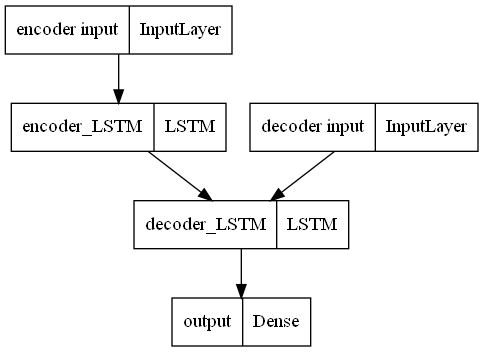

In [50]:
# Model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Summary
print(model.summary())

# Plot the model
plot_model(model)

In [31]:
# Train the model
model.fit([encoder_input_data, decoder_input_data],
           decoder_output_data,
           epochs=15,
           batch_size=128,
           validation_split=0.2)

Epoch 1/15
862/862 [==============================] - 26s 23ms/step - loss: 0.8768 - accuracy: 0.7586 - val_loss: 0.4525 - val_accuracy: 0.8406
Epoch 2/15
862/862 [==============================] - 19s 22ms/step - loss: 0.3681 - accuracy: 0.8710 - val_loss: 0.3001 - val_accuracy: 0.8964
Epoch 3/15
862/862 [==============================] - 19s 22ms/step - loss: 0.2329 - accuracy: 0.9225 - val_loss: 0.1512 - val_accuracy: 0.9491
Epoch 4/15
862/862 [==============================] - 19s 22ms/step - loss: 0.0738 - accuracy: 0.9764 - val_loss: 0.0378 - val_accuracy: 0.9884
Epoch 5/15
862/862 [==============================] - 19s 22ms/step - loss: 0.0327 - accuracy: 0.9897 - val_loss: 0.0294 - val_accuracy: 0.9905
Epoch 6/15
862/862 [==============================] - 19s 22ms/step - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.0208 - val_accuracy: 0.9935
Epoch 7/15
862/862 [==============================] - 19s 22ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0169 - val_accuracy:

In [32]:
# Save the model
model.save("./saved models/model_1_3.h5")

In [51]:
# Load the model
model = tf.keras.models.load_model("./saved models/model_1_3.h5")
print("Model got loaded.")

Model got loaded.


###### INFERENCE

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, None, 203)]       0         
                                                                 
 encoder_LSTM (LSTM)         [(None, 512),             1466368   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,466,368
Trainable params: 1,466,368
Non-trainable params: 0
_________________________________________________________________


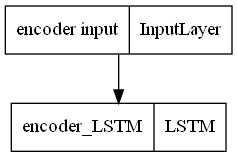

In [56]:
# Encoder input
encoder_inputs = tf.keras.layers.Input(shape=(None, num_encoder_tokens), 
                                       name="encoder input")

# Feed input to LSTM
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Context Vector (i.e. last hidden states and cell states of encoder)
context_vector = [state_h, state_c]

# Encoder model
encoder_model = tf.keras.Model(encoder_inputs, context_vector)

# Report
encoder_model.summary()
plot_model(encoder_model)

In [57]:
# Input - hidden state
decoder_state_input_h = keras.layers.Input(shape=(latent_dim,), name="hidden state input")

# Input - cell state
decoder_state_input_c = keras.layers.Input(shape=(latent_dim,), name="cell state input")

# Save the inputs
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder LSTM
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# Save the states
decoder_states = [state_h, state_c]

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder input (InputLayer)     [(None, None, 348)]  0           []                               
                                                                                                  
 hidden state input (InputLayer  [(None, 512)]       0           []                               
 )                                                                                                
                                                                                                  
 cell state input (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 decoder_LSTM (LSTM)            [(None, None, 512),  1763328     ['decoder input[0][0]',   

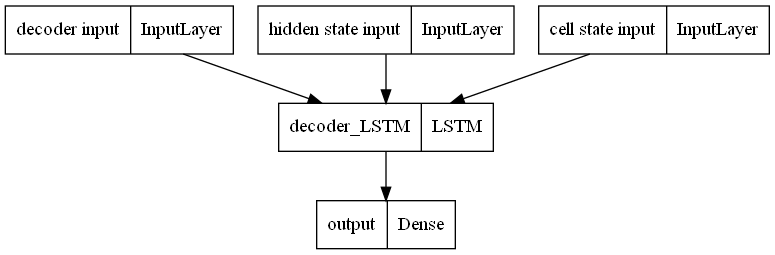

In [58]:
# Output dense
decoder_outputs = decoder_dense(decoder_outputs)

# Construct model
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Report
decoder_model.summary()
plot_model(decoder_model)

In [61]:
def decode_sequence(input_seq):
    
    # Encoder prediction (get context vector)
    states_value = encoder_model.predict(input_seq)

    # Initialize the target sequence with zeros - shape of (1, 1, NUM_DECODER_TOKEN)
    target_seq = np.zeros(shape=(1, 1, num_decoder_tokens))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = word2int_en["<SOS>"]

    # Initialize the maximum decoder length
    max_decoder_length = decoder_output_data.shape[-1]

    # Initialize the stop condition
    stop_condition = False

    # Initialize the decoded sentence
    decoded_sentence = []

    # While stop condition is false
    while not stop_condition:

        # Decoder prediction
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Find the maximum index value
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Add the predicted int to output sequence
        decoded_sentence.append(sampled_token_index) 

        # Exit condition
        #   1. Hitting maximum length
        #   2. Finding stop character
        if (sampled_token_index==word2int_en["<EOS>"]) or (len(decoded_sentence)==max_decoder_length):

            # Set stop condition to true
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros(shape=(1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states (context vector) 
        states_value = [h, c]

    return decoded_sentence, target_seq

In [59]:
# Initialize the sentence
sent = en[0]

# Preprocess the sentence
sent = text_preprocessing(sent)

# Encode the sentence
sent = encode(sent, language="english", word2int=word2int_en)

# Pad the sequence
sent_int = tf.keras.preprocessing.sequence.pad_sequences(sequences=[sent], maxlen=max_pad, padding="post", truncating="post")

# One-hot encoding
sent_one_hot = one_hot_encode(sequences=sent_int, tokens_num=len(word2int_en))

100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [62]:
decoded_sentence, target_seq = decode_sequence(sent_one_hot)

In [63]:
np.array(decoded_sentence)

array([266, 266, 344, 344,  20,  20, 201,  71,  34,  51,  20, 302, 294,
       245, 142, 245, 142, 245, 331, 149, 340, 179, 179, 269, 102, 269,
        34, 130, 130, 169, 236, 130, 169, 236, 236, 170, 236, 170, 153,
       169, 236, 170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169,
       236, 170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236,
       170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170,
       236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170, 236,
       170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170, 236, 170,
       153, 169, 236, 170, 236, 170, 153, 169, 236, 170, 236, 170, 153,
       169, 236, 170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169,
       236, 170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236,
       170, 236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170,
       236, 170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170, 236,
       170, 153, 169, 236, 170, 236, 170, 153, 169, 236, 170, 23

In [68]:
# Decode the sentence
pred_sent = decode(decoded_sentence, int2word=int2word_fr, word2int=word2int_fr)
pred_sent

"pêche pêche était était allée allée n'aimez clémentes avez californie allée temps singes poire humide poire humide poire vont jamais à magnifique magnifique qu'il enneigée qu'il avez glaciales glaciales lapins petites glaciales lapins petites petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins petites le petites le jersey lapins 

In [69]:
fr[0]

"new jersey est parfois calme pendant l' automne   et il est neigeux en avril  "

<br>

### 4.4. BAHDANAU (ADDITIVE) ATTENTION MECHANISM


In [20]:
# Encoder data
encoder_data  = x_train
print(f"Encoder Input Data - {encoder_data.shape}: ")
print(encoder_data[0])

Encoder Input Data - (130967, 26, 201): 
tf.Tensor(
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]], shape=(26, 201), dtype=int32)


In [21]:
# Decoder data
decoder_data  = y_train
print(f"\nDecoder Input Data - {decoder_data.shape}: ")
print(decoder_data[0])


Decoder Input Data - (130967, 26, 350): 
tf.Tensor(
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]], shape=(26, 350), dtype=int32)


In [22]:
# Hyperparameters
embedding_dim = 256
units = 1024
num_encoder_tokens = x_train.shape[-1]    # 203 
num_decoder_tokens = y_train.shape[-1]    # 348 
n_repeat_vector = max_len
latent_dim = 512

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None, 201)]  0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, None, 512),  1462272     ['encoder_input[0][0]']          
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 decoder_LSTM (LSTM)            (None, None, 512)    2099200     ['encoder_LSTM[0][0]',           
                                                                  'encoder_LSTM[0][1]',    

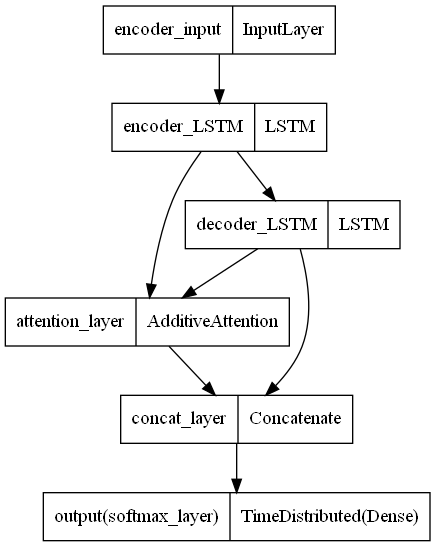

In [114]:
###########
# ENCODER #
###########

# Encoder input
encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens), name="encoder_input")

# Squeeze a dimension
#encoder_inputs = tf.squeeze(encoder_inputs, axis=1, name="encoder_input_squeezed")

# Embedding layer (i.e. convert tokens into vectors) 
#encoder_embedding = tf.keras.layers.Embedding(num_encoder_tokens, embedding_dim)(encoder_inputs)

# LSTM layer
all_hidden_states_enc, state_h_enc, state_c_enc = keras.layers.LSTM(latent_dim, 
                                                                    return_sequences=True, 
                                                                    return_state=True, 
                                                                    name="encoder_LSTM")(encoder_inputs, initial_state=None)


###########
# DECODER #
###########

# Decoder - LSTM layer
all_hidden_states_decoder = tf.keras.layers.LSTM(units=latent_dim, 
                                                 return_sequences=True, 
                                                 return_state=False,
                                                 name="decoder_LSTM")(all_hidden_states_enc, initial_state=[state_h_enc, state_c_enc])


############################
# ADDITIVE ATTENTION LAYER #
############################

# Additive attention layer
# The input for AdditiveAttention: query, key. It returns a tensor of shape as query
attn_out, attn_states = keras.layers.AdditiveAttention(name='attention_layer')([all_hidden_states_enc, all_hidden_states_decoder], return_attention_scores=True)

# Concatenate attention input and decoder output
decoder_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer')([all_hidden_states_decoder, attn_out])


##########
# OUTPUT #
##########

# Dense layer
dense = keras.layers.Dense(num_decoder_tokens, activation='softmax', name='softmax_layer')

# Time-distributed layer
dense_time = keras.layers.TimeDistributed(dense, name='output')

# Feed data
out = dense_time(decoder_concat_input)


#########
# MODEL #
#########

# Define the model
model = keras.Model(inputs=encoder_inputs, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Report
model.summary()
plot_model(model)

In [30]:
# Train the model
model.fit(encoder_data,
          decoder_data,
           epochs=15,
           batch_size=128,
           validation_split=0.2)

Epoch 1/15
819/819 [==============================] - 40s 39ms/step - loss: 1.0850 - accuracy: 0.7167 - val_loss: 0.5294 - val_accuracy: 0.8457
Epoch 2/15
819/819 [==============================] - 31s 38ms/step - loss: 0.3157 - accuracy: 0.9062 - val_loss: 0.2084 - val_accuracy: 0.9356
Epoch 3/15
819/819 [==============================] - 31s 37ms/step - loss: 0.1682 - accuracy: 0.9467 - val_loss: 0.1432 - val_accuracy: 0.9546
Epoch 4/15
819/819 [==============================] - 30s 37ms/step - loss: 0.1212 - accuracy: 0.9611 - val_loss: 0.1125 - val_accuracy: 0.9640
Epoch 5/15
819/819 [==============================] - 31s 37ms/step - loss: 0.0954 - accuracy: 0.9693 - val_loss: 0.1019 - val_accuracy: 0.9685
Epoch 6/15
819/819 [==============================] - 30s 37ms/step - loss: 0.0782 - accuracy: 0.9747 - val_loss: 0.0843 - val_accuracy: 0.9731
Epoch 7/15
819/819 [==============================] - 31s 37ms/step - loss: 0.0675 - accuracy: 0.9781 - val_loss: 0.0712 - val_accuracy:

In [78]:
# Function for inference
def inference(text):

    # Label encode
    encoded = label_encoding(text, word2int_en, "english")

    # Padding
    encoded = padding([encoded], max_len)[0]

    # One hot encoding
    encoded = one_hot_encoding(encoded, length=len(word2int_en)+1)

    # Expand first dimension
    encoded = np.expand_dims(encoded, 0)

    # Predict
    prediction = model.predict(encoded)[0]

    # One-hot decoding
    decoded = one_hot_decoding(prediction)

    # Label decoding
    decoded = " ".join(label_decoding(decoded, int2word_fr))

    # Remove tags
    for i_token in ["<SOS>", "<EOS>", "<UNK>"]: decoded = decoded.replace(i_token, "").strip()

    return decoded

In [80]:
# Input/Output text 
input_text = "new jersey is sometimes quiet during autumn and it is snowy in april"
output_text = "new jersey est parfois calme pendant l' automne et il est neigeux en avril"

# Predict the sentence
prediction = inference(input_text)

# Report
print("Input text: ", input_text)
print("Prediction: ", prediction)
print("True label: ", output_text)

Input text:  new jersey is sometimes quiet during autumn and it is snowy in april
Prediction:  new jersey est parfois calme pendant l ' automne et il est neigeux en avril
True label:  new jersey est parfois calme pendant l' automne et il est neigeux en avril


https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

<br>

### 4.5. LUONG ATTENTION MECHANISM

In [91]:
# Encoder data
encoder_data  = x_train
print(f"Encoder Input Data - {encoder_data.shape}: ")
print(encoder_data[0])

Encoder Input Data - (130967, 26, 201): 
tf.Tensor(
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]], shape=(26, 201), dtype=int32)


In [92]:
# Decoder data
decoder_data  = y_train
print(f"\nDecoder Input Data - {decoder_data.shape}: ")
print(decoder_data[0])


Decoder Input Data - (130967, 26, 350): 
tf.Tensor(
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]], shape=(26, 350), dtype=int32)


In [93]:
# Hyperparameters
embedding_dim = 256
units = 1024
num_encoder_tokens = x_train.shape[-1]    # 203 
num_decoder_tokens = y_train.shape[-1]    # 348 
n_repeat_vector = max_len
latent_dim = 512

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None, 201)]  0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, None, 512),  1462272     ['encoder_input[0][0]']          
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 decoder_LSTM (LSTM)            (None, None, 512)    2099200     ['encoder_LSTM[0][0]',           
                                                                  'encoder_LSTM[0][1]',     

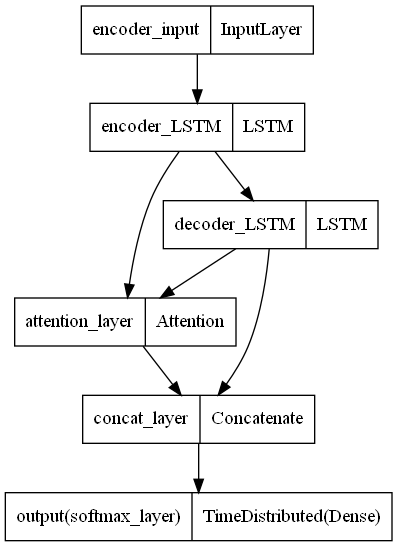

In [94]:
###########
# ENCODER #
###########

# Encoder input
encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens), name="encoder_input")

# Squeeze a dimension
#encoder_inputs = tf.squeeze(encoder_inputs, axis=1, name="encoder_input_squeezed")

# Embedding layer (i.e. convert tokens into vectors) 
#encoder_embedding = tf.keras.layers.Embedding(num_encoder_tokens, embedding_dim)(encoder_inputs)

# LSTM layer
all_hidden_states_enc, state_h_enc, state_c_enc = keras.layers.LSTM(latent_dim, 
                                                                    return_sequences=True, 
                                                                    return_state=True, 
                                                                    name="encoder_LSTM")(encoder_inputs, initial_state=None)


###########
# DECODER #
###########

# Decoder - LSTM layer
all_hidden_states_decoder = tf.keras.layers.LSTM(units=latent_dim, 
                                                 return_sequences=True, 
                                                 return_state=False,
                                                 name="decoder_LSTM")(all_hidden_states_enc, initial_state=[state_h_enc, state_c_enc])


############################
# ADDITIVE ATTENTION LAYER #
############################

# Dot-product attention layer
attn_out, attn_states = keras.layers.Attention(name='attention_layer')([all_hidden_states_enc, all_hidden_states_decoder], return_attention_scores=True)

# Concatenate attention input and decoder output
decoder_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer')([all_hidden_states_decoder, attn_out])


##########
# OUTPUT #
##########

# Dense layer
dense = keras.layers.Dense(num_decoder_tokens, activation='softmax', name='softmax_layer')

# Time-distributed layer
dense_time = keras.layers.TimeDistributed(dense, name='output')

# Feed data
out = dense_time(decoder_concat_input)


#########
# MODEL #
#########

# Define the model
model = keras.Model(inputs=encoder_inputs, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Report
model.summary()
plot_model(model)

In [95]:
# Train the model
model.fit(encoder_data,
          decoder_data,
           epochs=15,
           batch_size=128,
           validation_split=0.2)

Epoch 1/15
819/819 [==============================] - 22s 24ms/step - loss: 1.0261 - accuracy: 0.7388 - val_loss: 0.5228 - val_accuracy: 0.8483
Epoch 2/15
819/819 [==============================] - 19s 23ms/step - loss: 0.3519 - accuracy: 0.8959 - val_loss: 0.2435 - val_accuracy: 0.9255
Epoch 3/15
819/819 [==============================] - 18s 23ms/step - loss: 0.1956 - accuracy: 0.9374 - val_loss: 0.1616 - val_accuracy: 0.9474
Epoch 4/15
819/819 [==============================] - 19s 23ms/step - loss: 0.1382 - accuracy: 0.9549 - val_loss: 0.1278 - val_accuracy: 0.9577
Epoch 5/15
819/819 [==============================] - 19s 23ms/step - loss: 0.1094 - accuracy: 0.9642 - val_loss: 0.1113 - val_accuracy: 0.9639
Epoch 6/15
819/819 [==============================] - 19s 23ms/step - loss: 0.0867 - accuracy: 0.9715 - val_loss: 0.0910 - val_accuracy: 0.9702
Epoch 7/15
819/819 [==============================] - 19s 23ms/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.0762 - val_accuracy:

In [96]:
# Function for inference
def inference(text):

    # Label encode
    encoded = label_encoding(text, word2int_en, "english")

    # Padding
    encoded = padding([encoded], max_len)[0]

    # One hot encoding
    encoded = one_hot_encoding(encoded, length=len(word2int_en)+1)

    # Expand first dimension
    encoded = np.expand_dims(encoded, 0)

    # Predict
    prediction = model.predict(encoded)[0]

    # One-hot decoding
    decoded = one_hot_decoding(prediction)

    # Label decoding
    decoded = " ".join(label_decoding(decoded, int2word_fr))

    # Remove tags
    for i_token in ["<SOS>", "<EOS>", "<UNK>"]: decoded = decoded.replace(i_token, "").strip()

    return decoded

In [105]:
# Input/Output text 
input_text = en[0]
output_text = fr[0]

# Predict the sentence
prediction = inference(input_text)

# Report
print("Input text: ", input_text)
print("Prediction: ", prediction)
print("True label: ", output_text)

Input text:  new jersey is sometimes quiet during autumn and it is snowy in april
Prediction:  new jersey est parfois calme pendant l ' automne et il est neigeux en avril
True label:  new jersey est parfois calme pendant l' automne et il est neigeux en avril
